# 📝 ✍️ 👄프로젝트 : 번역기를 만들어보자

실습에서 구현한 번역기는 글자 단위(Character-level)에서 구현된 번역기였습니다. 하지만 실제 번역기의 경우에는 글자 단위가 아니라 단어 단위(Word-level)에서 구현되는 것이 좀 더 보편적입니다.

동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 to_categorical() 함수가 아닌 임베딩 층(Embedding layer)를 추가하여 단어 단위의 번역기를 완성시켜보겠습니다. 하지만, 단어 단위로 할 경우에는 단어의 개수가 글자 단위로 했을 경우와 비교하여 단어장의 크기(Vocabulary) 크기도 커지고, 학습 속도도 좀 더 느려집니다. 학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플만 사용해주세요.

33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다.

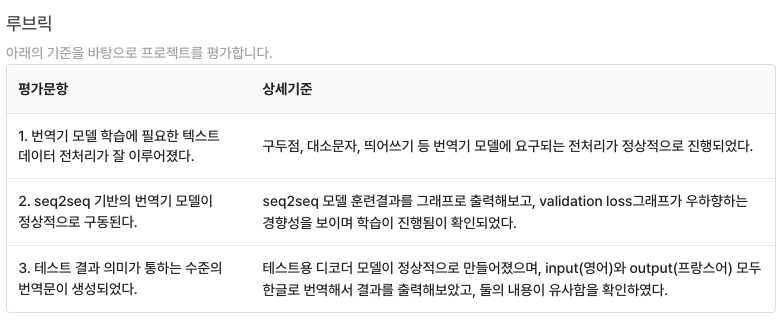

## Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

글자 단위가 아닌 단어 단위의 번역기를 하기 위해서는 글자 단위에서는 신경쓰지 않았던 몇 가지 추가적인 전처리가 필요합니다.

1. 구두점(Punctuation)을 단어와 분리해주세요.

일반적으로 영어권 언어의 경우에는 띄어쓰기 단위로 단어를 분리합니다. 토큰화(Tokenization) 라고도 불리는 이 작업은 어디서부터 어디까지가 하나의 단어인지를 구분하는 작업인데요, 그런데 띄어쓰기를 해주기 전에 구두점을 분리하는 작업이 필요할 때가 있습니다.

예를 들어서 'he is a good boy!'라는 문장이 있을 때, 이를 띄어쓰기 단위로 토큰화한다면 ['he', 'is', 'a', 'good', 'boy!']가 됩니다. 그런데 실제로 !는 boy와 붙어있는 한 단어가 아니므로 좀 더 올바른 전처리는 ['he', 'is', 'a', 'good', 'boy', '!']가 맞습니다.
!나 ? 또는 온점과 같은 특수문자들을 구두점(punctuation)이라고 부릅니다. 이들을 토큰화하기 전에 단어와 미리 분리시켜주세요!

- 분리 전 : he is a Good boy!
- 분리 후 : he is a Good boy !

2. 소문자로 바꿔주세요.

기계가 보기에는 스펠링이 같더라도 대문자로 된 단어와 소문자로 된 단어는 서로 다른 단어입니다. 예를 들어 'Good'과 'good'은 기계가 보기에는 다른 단어입니다. 그래서 모든 문장에 대해서 전부 영어로 바꿔주는 작업을 하겠습니다.

- 변환 전 : he is a Good boy !
- 변환 후 : he is a good boy !

3. 띄어쓰기 단위로 토큰화를 수행하세요.

띄어쓰기 단위로 토큰화를 수행해서 단어를 분리하는 작업을 해주세요. 기계는 이렇게 분리된 토큰들을 각각 하나의 단어로 인식할 수 있게 됩니다.

- 토큰화 전 : 'he is a good boy !'
- 토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']


## Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

글자 단위 번역기를 구현할 때와 마찬가지로 디코더의 입력 시퀀스 맨 앞에는 시작을 의미하는 토큰인 <sos>가 필요합니다. 그리고 교사 강요를 수행할 때, 디코더의 실제값이 되는 디코더의 레이블 시퀀스에는 종료를 의미하는 종료 토큰 <eos>가 필요합니다.
예를 들어 번역 문장이 "Courez!" 였다고 한다면, Step 1을 거친 후에는 다음과 같은 결과를 얻습니다.

Step 1을 수행한 후 : ['courez', '!']
이 문장에 대해서 각각 디코더의 입력 시퀀스와 레이블 시퀀스를 만들면 다음과 같습니다.

입력 시퀀스 : ['<sos>', 'courez', '!']
레이블 시퀀스 : ['courez', '!', '<eos>']
참고로 Step 2가 반드시 Step 1이 끝난 후에 이루어질 필요는 없습니다!
Step 1을 수행하는 중간에 수행해도 상관없습니다.

## Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

딥러닝 모델은 텍스트가 아닌 숫자를 처리합니다. 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꿔보세요.
케라스 토크나이저의 사용법은 아래의 링크에서 2. 케라스(Keras)의 텍스트 전처리에 설명되어 있습니다.

- https://wikidocs.net/31766

위 링크의 가이드를 통해서 영어와 프랑스어에 대한 토크나이저를 각각 생성하고, tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보세요.

## Step 4. 임베딩 층(Embedding layer) 사용하기

이번에는 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화하겠습니다.
임베딩 층을 사용하는 방법과 그 설명에 대해서는 아래의 링크의 1. 케라스 임베딩 층(Keras Embedding layer) 을 참고하세요.

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Masking

# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(단어장의 크기, 임베딩 벡터의 차원)(encoder_inputs)
encoder_lstm = LSTM(hidden state의 크기, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

실제 번역기 구현을 위해서 사용할 수 있는 인코더 코드의 예시는 다음과 같습니다. 이를 통해서 인코더와 디코더의 임베딩 층을 각각 구현해보세요.

주의할 점은 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만, 디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야 한다는 것입니다!

## Step 5. 모델 구현하기

글자 단위 번역기에서 구현한 모델을 참고로 단어 단위 번역기의 모델을 완성시켜보세요! 이때는 label이 integer 값이므로 categorical entropy loss가 아닌 sparse categorical entropy loss를 사용합니다.

## Step 6. 모델 평가하기

단어 단위 번역기를 이용하여 훈련 데이터의 샘플과 테스트 데이터의 샘플로 번역 문장을 만들어보고 정답 문장과 번역 문장을 비교해보세요. 이전 스텝들에서 우리가 공부했던 모델의 경우 글자 단위에서 구현된 번역기이며 현재 프로젝트를 진행할 때 사용하는 모델은 단어 단위에서 구현되는 번역기입니다.

>Embedding layer가 추가되기 때문에 학습했던 내용 그대로 사용할 경우 shape에서 error가 발생합니다.
decode sentence를 구성할 때 고민해보세요!!

고민하다 풀리지 않을 경우에는 하단 내용 참고해주세요.

In [ ]:

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['\t']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence